
# Detección de Fraude con Redes Neuronales (MLP, LSTM/GRU y Autoencoder)


---

## Objetivo
Construir una solución de **detección de fraude en transacciones** y **comparar al menos 3 tipos de redes neuronales**:
1. **MLP (Perceptrón Multicapa)** para datos tabulares.
2. **LSTM/GRU (red recurrente)** para capturar **patrones secuenciales** en las transacciones.
3. **Autoencoder** entrenado en clase negativa (no fraude) para **detección de anomalías** vía error de reconstrucción.




In [20]:

# ==========================
# 0. Librerías y Config
# ==========================
import os, sys, math, json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Opcionales para imbalance
try:
    from imblearn.under_sampling import RandomUnderSampler
    IMBLEARN_AVAILABLE = True
except Exception as e:
    print("[AVISO] 'imbalanced-learn' no está disponible, se continuará sin submuestreo explícito.")
    IMBLEARN_AVAILABLE = False

# Deep Learning (Keras/TensorFlow)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
    print("TensorFlow:", tf.__version__)
except Exception as e:
    TF_AVAILABLE = False
    print("[AVISO] TensorFlow no está disponible. Este cuaderno incluye el código, pero debes instalarlo localmente para ejecutar los modelos neuronales.")
    print("Instala: pip install tensorflow")

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
if TF_AVAILABLE:
    tf.random.set_seed(SEED)

# Plot config
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True


TensorFlow: 2.19.0



---
## 1. Carga del Dataset (Real o Sintético)

Intentaremos cargar el dataset real `creditcard.csv`.  
Si **no existe**, generaremos un **dataset sintético** con:
- ~50.000 transacciones, ~1.500 clientes
- Variables tabulares realistas (monto, hora, categoría de comercio, riesgo del comercio, país, etc.)
- **Desbalance severo** (≈1% de fraudes)
- **Secuencias por cliente** (timestamps) para usar en LSTM/GRU


In [21]:

# ==========================
# 1. Dataset real o sintético
# ==========================
DATA_PATH = "creditcard.csv"

def generate_synthetic_dataset(n_customers=1500, tx_per_customer_mean=35, fraud_rate=0.012):
    """
    Genera un dataset sintético con estructura transaccional por cliente.
    - Cada transacción tiene timestamp, amount, hour, merchant_category, merchant_risk, country, device_score, etc.
    - La probabilidad de fraude depende de varias señales semi-realistas.
    """
    rng = np.random.default_rng(SEED)

    customers = np.arange(n_customers)
    rows = []
    merchant_categories = np.arange(10)  # 0..9
    countries = np.arange(6)             # 0..5

    for cid in customers:
        # Número de transacciones del cliente
        n_tx = max(3, int(rng.poisson(tx_per_customer_mean)))
        # Inicio de ventana temporal (un día aleatorio como base)
        base_ts = rng.integers(0, 60*60*24*30)  # dentro de ~30 días
        # Tendencia de gasto del cliente
        base_spend = rng.uniform(5, 150)
        # Tendencia de riesgo del cliente (0: bajo, 1: alto)
        client_risk = rng.uniform(0, 1)

        last_ts = base_ts
        fraud_memory = 0
        for i in range(n_tx):
            # Timestamp incremental (segundos entre tx)
            delta = int(rng.exponential(scale=60*60*6))  # ~cada 6 horas promedio
            ts = last_ts + delta
            last_ts = ts

            hour = (ts // 3600) % 24
            merchant_cat = rng.choice(merchant_categories, p=np.linspace(0.2, 0.8, 10)/np.linspace(0.2, 0.8, 10).sum())
            merchant_risk = merchant_cat / merchant_categories.max()  # proxy de riesgo
            country = rng.choice(countries, p=[0.50, 0.20, 0.12, 0.08, 0.06, 0.04])

            # Monto (exponencial con sesgo por categoría y riesgo)
            amount = rng.exponential(scale=base_spend*(1+0.6*merchant_risk)) + rng.normal(0, 2)
            amount = max(0.1, amount)

            # Señales "sospechosas"
            device_score = rng.uniform(0, 1)
            new_device = (device_score > 0.85) * 1.0
            odd_hour = 1.0 if hour in [1,2,3,4] else 0.0
            high_amount = 1.0 if amount > (base_spend*3.5) else 0.0

            # Probabilidad de fraude (logística con varias señales)
            logit = (
                -5.0
                + 2.2*high_amount
                + 1.4*odd_hour
                + 1.6*new_device
                + 1.2*merchant_risk
                + 0.8*client_risk
                + 0.5*(country==5)
                + 0.4*fraud_memory
            )
            p_fraud = 1/(1+np.exp(-logit))
            # Mezclar con tasa objetivo
            p_fraud = 0.5*p_fraud + 0.5*fraud_rate

            is_fraud = rng.random() < p_fraud
            fraud_memory = 0.7*fraud_memory + (1.0 if is_fraud else 0.0)

            rows.append({
                "customer_id": cid,
                "timestamp": int(ts),
                "amount": float(amount),
                "hour": int(hour),
                "merchant_cat": int(merchant_cat),
                "merchant_risk": float(merchant_risk),
                "country": int(country),
                "device_score": float(device_score),
                "new_device": float(new_device),
                "odd_hour": float(odd_hour),
                "high_amount": float(high_amount),
                "is_fraud": int(is_fraud)
            })

    df = pd.DataFrame(rows).sort_values(["customer_id", "timestamp"]).reset_index(drop=True)
    # Asegurar desbalance aproximado
    curr_rate = df["is_fraud"].mean()
    print(f"Sintético: {len(df):,} transacciones, fraude ~{curr_rate*100:.2f}%")
    return df

def load_or_synthesize():
    if os.path.exists(DATA_PATH):
        print("Cargando dataset real:", DATA_PATH)
        df = pd.read_csv(DATA_PATH)
        # Estandarización mínima a columnas esperadas
        # Si es el dataset de Kaggle: columnas [Time, V1..V28, Amount, Class]
        # Renombrar a un formato unificado
        if {"Time","Amount","Class"}.issubset(df.columns):
            df = df.rename(columns={"Time":"timestamp","Amount":"amount","Class":"is_fraud"})
            # Inyectamos customer_id sintético y hour
            rng = np.random.default_rng(SEED)
            n = len(df)
            df["customer_id"] = rng.integers(0, 2000, size=n)
            df["hour"] = (df["timestamp"]//3600)%24
            # Si faltan columnas "estilo sintético", las creamos
            if "merchant_cat" not in df.columns:
                df["merchant_cat"] = rng.integers(0,10,size=n)
                df["merchant_risk"] = df["merchant_cat"]/9.0
                df["country"] = rng.integers(0,6,size=n)
                df["device_score"] = rng.uniform(0,1,size=n)
                df["new_device"] = (df["device_score"]>0.85).astype(float)
                df["odd_hour"] = df["hour"].isin([1,2,3,4]).astype(float)
                df["high_amount"] = (df["amount"]>(df["amount"].median()*3.5)).astype(float)
        else:
            print("[AVISO] Estructura desconocida. Se generará dataset sintético para el flujo completo.")
            df = generate_synthetic_dataset()
    else:
        print("No se encontró 'creditcard.csv'. Generando dataset sintético...")
        df = generate_synthetic_dataset()
    return df

df = load_or_synthesize()
df.head()


Cargando dataset real: creditcard.csv


,timestamp,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,is_fraud,customer_id,hour,merchant_cat,merchant_risk,country,device_score,new_device,odd_hour,high_amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.0,178,0,5,0.555556,0,0.606939,0.0,0.0,1.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.0,1547,0,6,0.666667,4,0.739724,0.0,0.0,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.0,1309,0,2,0.222222,5,0.289981,0.0,0.0,1.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.0,877,0,7,0.777778,3,0.676435,0.0,0.0,1.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.0,866,0,1,0.111111,2,0.170900,0.0,0.0,0.0



---
## 2. Análisis Exploratorio Breve (EDA)

- **Balance de clases** (fraude vs no fraude)  
- Distribución de **monto** y **hora**  
- Ejemplos de variables categóricas (p. ej., `merchant_cat`, `country`)


Fraude: 0.27%

Conteo por clase:
is_fraud
0.0    59348
1.0      162
Name: count, dtype: int64


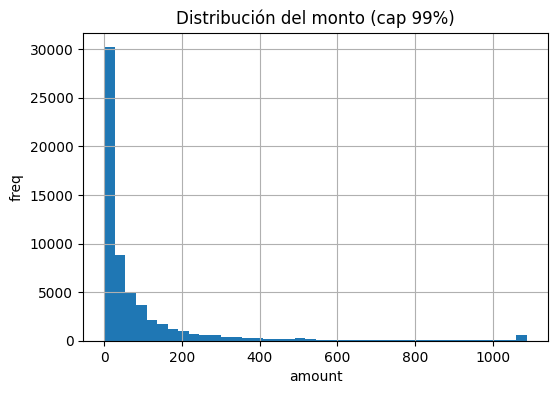

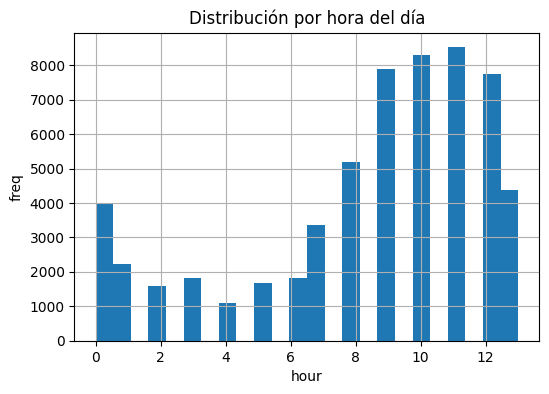

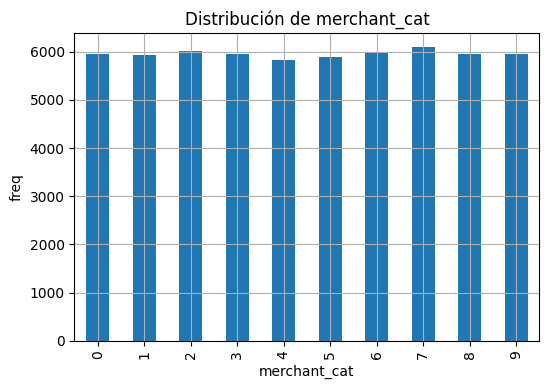

In [22]:

fraud_rate = df["is_fraud"].mean()
print(f"Fraude: {fraud_rate*100:.2f}%")

print("\nConteo por clase:")
print(df["is_fraud"].value_counts())

fig, ax = plt.subplots()
df["amount"].clip(upper=df["amount"].quantile(0.99)).hist(bins=40, ax=ax)
ax.set_title("Distribución del monto (cap 99%)")
ax.set_xlabel("amount"); ax.set_ylabel("freq")
plt.show()

fig, ax = plt.subplots()
df["hour"].hist(bins=24, ax=ax)
ax.set_title("Distribución por hora del día")
ax.set_xlabel("hour"); ax.set_ylabel("freq")
plt.show()

if "merchant_cat" in df.columns:
    fig, ax = plt.subplots()
    df["merchant_cat"].value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set_title("Distribución de merchant_cat")
    ax.set_xlabel("merchant_cat"); ax.set_ylabel("freq")
    plt.show()



---
## 3. Preprocesamiento (Tabular) para MLP

- Seleccionamos variables **tabulares** (numéricas + categóricas codificadas).  
- **Escalado** con `StandardScaler`.  
- `train/val/test` con **estratificación** por clase.  
- Manejo de **desbalance**: `class_weight` y (opcional) `RandomUnderSampler` si `imbalanced-learn` está disponible.


In [24]:
# Selección de features tabulares generales
base_features = ["amount","hour","merchant_cat","merchant_risk","country","device_score","new_device","odd_hour","high_amount"]
# Añadir columnas PCA si existen (dataset real)
pca_cols = [c for c in df.columns if c.startswith("V") and df[c].dtype != 'O']
features = base_features + pca_cols
features = [c for c in features if c in df.columns]

print("Nº de features tabulares:", len(features))

# Asegurarse de que 'is_fraud' solo contenga 0 y 1, manejando posibles errores
df['is_fraud'] = pd.to_numeric(df['is_fraud'], errors='coerce')
df.dropna(subset=['is_fraud'], inplace=True)
y = df["is_fraud"].values.astype(np.int32)
X = df[features].values.astype(np.float32)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print("Shapes ->", X_train.shape, X_val.shape, X_test.shape)

# Opcional: submuestreo de clase mayoritaria SOLO en train (para estabilizar)
if IMBLEARN_AVAILABLE:
    rus = RandomUnderSampler(random_state=SEED)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    print("Tras RUS (train):", X_train.shape, "fraud_rate:", y_train.mean())

# Pesos por clase (para Keras)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(k):float(v) for k,v in zip(classes, class_weights)}
print("class_weights:", class_weights)

Nº de features tabulares: 37
Shapes -> (41657, 37) (8926, 37) (8927, 37)
Tras RUS (train): (226, 37) fraud_rate: 0.5
class_weights: {0: 1.0, 1: 1.0}



---
## 4. Modelo 1 — **MLP (Perceptrón Multicapa)**

Arquitectura sugerida:
- Densas intermedias con activación ReLU
- Dropout ligero para regularización
- Capa de salida sigmoidal (binaria)

Métrica principal: **AUC-ROC** y **F1** (equilibrio entre precision y recall).


In [25]:

if TF_AVAILABLE:
    mlp = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC','Precision','Recall'])
    mlp.summary()
else:
    print("[INFO] TensorFlow no disponible. Se muestra el código, pero no se entrenará el MLP.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
if TF_AVAILABLE:
    es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc', mode='max')
    hist_mlp = mlp.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=512,
        class_weight=class_weights,
        callbacks=[es], verbose=1
    )
else:
    hist_mlp = None

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 0.1028 - Precision: 0.1613 - Recall: 0.0885 - loss: 2.0825 - val_AUC: 0.1399 - val_Precision: 5.9371e-04 - val_Recall: 0.1250 - val_loss: 0.7301
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.1394 - Precision: 0.1781 - Recall: 0.1150 - loss: 1.6446

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - AUC: 0.1394 - Precision: 0.1781 - Recall: 0.1150 - loss: 1.6446 - val_AUC: 0.2416 - val_Precision: 7.2307e-04 - val_Recall: 0.1667 - val_loss: 0.7450
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.2786 - Precision: 0.3596 - Recall: 0.2832 - loss: 1.2480 - val_AUC: 0.4750 - val_Precision: 0.0020 - val_Recall: 0.5000 - val_loss: 0.7588
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - AUC: 0.4507 - Precision: 0.4911 - Recall: 0.4867 - loss: 0.9419 - val_AUC: 0.8456 - val_Precision: 0.0034 - val_Recall: 0.8750 - val_loss: 0.7708
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - AUC: 0.7302 - Precision: 0.5677 - Recall: 0.7788 - loss: 0.6481 - val_AUC: 0.9497 - val_Precision: 0.0037 - val_Recall: 0.9583 - val_loss: 0.7775
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - AUC: 0.8183 - Precision: 0.5839 - Recall: 0.8319 - loss: 0.5644 - val_AUC: 0.9541 - val_Precision: 0.0037 - val_Recall: 0.9583 - val_loss: 0.7776
Epoch 7/50
1/1 ━━

In [27]:

def evaluate_binary(model, X, y, name="model"):
    proba = model.predict(X, verbose=0).ravel()
    preds = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y, proba)
    print(f"[{name}] AUC-ROC: {auc:.4f}")
    print(classification_report(y, preds, digits=4))
    cm = confusion_matrix(y, preds)
    return {"name":name, "auc":auc, "cm":cm, "proba":proba, "preds":preds}

metrics_table = []
if TF_AVAILABLE:
    print("== Validación MLP ==")
    m_mlp_val = evaluate_binary(mlp, X_val, y_val, name="MLP (val)")
    m_mlp_test = evaluate_binary(mlp, X_test, y_test, name="MLP (test)")
    metrics_table.append(("MLP", m_mlp_test["auc"]))


== Validación MLP ==
[MLP (val)] AUC-ROC: 0.9495
              precision    recall  f1-score   support

           0     0.9998    0.9885    0.9941      8902
           1     0.1774    0.9167    0.2973        24

    accuracy                         0.9883      8926
   macro avg     0.5886    0.9526    0.6457      8926
weighted avg     0.9976    0.9883    0.9923      8926

[MLP (test)] AUC-ROC: 0.9988
              precision    recall  f1-score   support

           0     0.9999    0.9884    0.9941      8902
           1     0.1890    0.9600    0.3158        25

    accuracy                         0.9883      8927
   macro avg     0.5944    0.9742    0.6550      8927
weighted avg     0.9976    0.9883    0.9922      8927




---
## 5. Construcción de Secuencias y Modelo 2 — **LSTM/GRU**

Para capturar **patrones temporales**, construiremos **ventanas deslizantes** de longitud fija `T=10` transacciones por cliente:
- Ordenamos por `customer_id` y `timestamp`.
- Para cada transacción `t`, usamos las `T` anteriores como secuencia de entrada.
- Etiqueta = `is_fraud` de la transacción actual.

**Nota:** Si usas el dataset real de Kaggle, los `customer_id` son sintéticos. El propósito es evaluar la **capacidad secuencial** de la arquitectura.


In [28]:

SEQ_FEATURES = [c for c in ["amount","hour","merchant_cat","merchant_risk","country","device_score","new_device","odd_hour","high_amount"] if c in df.columns]
T = 10  # longitud de ventana

def build_sequences(df, features, T=10):
    X_seq, y_seq = [], []
    # Normalizamos por columna para estabilidad (solo estadísticas globales)
    data = df.copy()
    scaler_seq = StandardScaler()
    data[features] = scaler_seq.fit_transform(data[features].astype(np.float32))

    for cid, g in data.sort_values(["customer_id","timestamp"]).groupby("customer_id"):
        g = g.reset_index(drop=True)
        values = g[features].values.astype(np.float32)
        labels = g["is_fraud"].values.astype(np.int32)
        if len(g) <= T:
            continue
        for i in range(T, len(g)):
            X_seq.append(values[i-T:i, :])
            y_seq.append(labels[i])
    X_seq = np.stack(X_seq, axis=0)
    y_seq = np.array(y_seq)
    return X_seq, y_seq

X_seq, y_seq = build_sequences(df, SEQ_FEATURES, T=T)
print("Secuencias:", X_seq.shape, y_seq.shape)

X_seq_train, X_seq_temp, y_seq_train, y_seq_temp = train_test_split(
    X_seq, y_seq, test_size=0.3, random_state=SEED, stratify=y_seq
)
X_seq_val, X_seq_test, y_seq_val, y_seq_test = train_test_split(
    X_seq_temp, y_seq_temp, test_size=0.5, random_state=SEED, stratify=y_seq_temp
)

# Pesos por clase para secuencias
classes_s = np.unique(y_seq_train)
class_weights_seq = compute_class_weight(class_weight="balanced", classes=classes_s, y=y_seq_train)
class_weights_seq = {int(k):float(v) for k,v in zip(classes_s, class_weights_seq)}
print("class_weights (seq):", class_weights_seq)


Secuencias: (39510, 10, 9) (39510,)
class_weights (seq): {0: 0.5011233919188258, 1: 223.04032258064515}


In [29]:

if TF_AVAILABLE:
    inp = keras.Input(shape=(T, len(SEQ_FEATURES)))
    x = keras.layers.Masking(mask_value=0.0)(inp)
    x = keras.layers.GRU(64, return_sequences=False)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    rnn = keras.Model(inp, out, name="GRU_Fraud")
    rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC','Precision','Recall'])
    rnn.summary()
else:
    print("[INFO] TensorFlow no disponible. Se muestra el código del modelo secuencial.")


Model: "GRU_Fraud"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 10, 9)     │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 10, 9)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 10)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 64)        │     14,400 │ masking_1[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:

if TF_AVAILABLE:
    es2 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc', mode='max')
    hist_rnn = rnn.fit(
        X_seq_train, y_seq_train,
        validation_data=(X_seq_val, y_seq_val),
        epochs=40, batch_size=512,
        class_weight=class_weights_seq,
        callbacks=[es2], verbose=1
    )
else:
    hist_rnn = None


Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - AUC: 0.5251 - Precision: 0.0028 - Recall: 0.4442 - loss: 0.7262 - val_AUC: 0.5066 - val_Precision: 0.0026 - val_Recall: 0.3077 - val_loss: 0.6429
Epoch 2/40
 3/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - AUC: 0.6457 - Precision: 0.0083 - Recall: 0.5111 - loss: 1.0479

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - AUC: 0.6092 - Precision: 0.0037 - Recall: 0.4764 - loss: 0.7103 - val_AUC: 0.5171 - val_Precision: 0.0025 - val_Recall: 0.3846 - val_loss: 0.6436
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - AUC: 0.5928 - Precision: 0.0031 - Recall: 0.4556 - loss: 0.7103 - val_AUC: 0.5163 - val_Precision: 0.0019 - val_Recall: 0.3077 - val_loss: 0.6406
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - AUC: 0.6108 - Precision: 0.0032 - Recall: 0.4950 - loss: 0.7063 - val_AUC: 0.5234 - val_Precision: 0.0025 - val_Recall: 0.3846 - val_loss: 0.6347
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - AUC: 0.6469 - Precision: 0.0040 - Recall: 0.5899 - loss: 0.6929 - val_AUC: 0.5226 - val_Precision: 0.0025 - val_Recall: 0.3846 - val_loss: 0.6269
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - AUC: 0.6590 - Precision: 0.0039 - Recall: 0.5858 - loss: 0.6855 - val_AUC: 0.5269 - val_Precision: 0.0025 - val_Recall: 0.3846 - val_loss: 0.6153
Epoch 7/40
55/55

In [31]:

if TF_AVAILABLE:
    print("== Validación GRU ==")
    m_rnn_val = evaluate_binary(rnn, X_seq_val, y_seq_val, name="GRU (val)")
    m_rnn_test = evaluate_binary(rnn, X_seq_test, y_seq_test, name="GRU (test)")
    metrics_table.append(("GRU", m_rnn_test["auc"]))


== Validación GRU ==
[GRU (val)] AUC-ROC: 0.5822
              precision    recall  f1-score   support

           0     0.9979    0.9871    0.9925      5913
           1     0.0130    0.0769    0.0222        13

    accuracy                         0.9852      5926
   macro avg     0.5055    0.5320    0.5074      5926
weighted avg     0.9958    0.9852    0.9904      5926

[GRU (test)] AUC-ROC: 0.6250
              precision    recall  f1-score   support

           0     0.9976    0.9866    0.9921      5913
           1     0.0000    0.0000    0.0000        14

    accuracy                         0.9843      5927
   macro avg     0.4988    0.4933    0.4960      5927
weighted avg     0.9952    0.9843    0.9897      5927




---
## 6. Modelo 3 — **Autoencoder** (Anomalías por error de reconstrucción)

Entrenamos un autoencoder **solo con transacciones no fraudulentas** (train).  
La hipótesis: las transacciones normales se reconstruyen bien, las fraudulentas no.

**Estrategia de umbral**:
- Opción 1: percentil del error de reconstrucción en `val` (p. ej., 95º).
- Opción 2: buscar el umbral que maximice F1 en `val`

Evaluamos en `test` con ese umbral.


In [32]:

if TF_AVAILABLE:
    # Datos tabulares para AE
    Xn_train = X_train[y_train==0]

    inp = keras.Input(shape=(X_train.shape[1],))
    x = keras.layers.Dense(128, activation='relu')(inp)
    x = keras.layers.Dense(64, activation='relu')(x)
    bottleneck = keras.layers.Dense(16, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(bottleneck)
    x = keras.layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(X_train.shape[1], activation='linear')(x)
    ae = keras.Model(inp, out, name="AE_Fraud")
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    ae.summary()
else:
    print("[INFO] TensorFlow no disponible. Se muestra el código del Autoencoder.")


Model: "AE_Fraud"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 37)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,341 (110.71 KB)

 Trainable params: 28,341 (110.71 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:

if TF_AVAILABLE:
    es3 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    hist_ae = ae.fit(
        Xn_train, Xn_train,
        validation_data=(X_val[y_val==0], X_val[y_val==0]),
        epochs=50, batch_size=512, verbose=1, callbacks=[es3]
    )
else:
    hist_ae = None


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9226 - val_loss: 0.9370
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.9125 - val_loss: 0.9334
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.9040 - val_loss: 0.9302
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.8966 - val_loss: 0.9272
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.8897 - val_loss: 0.9242
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.8825 - val_loss: 0.9210
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.8748 - val_loss: 0.9177
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.8663 - val_loss: 0.9143
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.8571 - val_loss: 0.9107
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.8473 - val_loss: 0.9068
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.8370 - val_loss: 0.9028
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.8261 - val_loss:

In [34]:

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def ae_scores(ae, X):
    X_pred = ae.predict(X, verbose=0)
    err = np.mean((X - X_pred)**2, axis=1)
    return err

def pick_threshold_by_f1(y_true, scores):
    # Barrer umbrales y elegir el que maximiza F1
    thresholds = np.quantile(scores, np.linspace(0.80, 0.999, 50))  # rango alto
    best_f1, best_thr = -1, None
    best_prec, best_rec = None, None
    for thr in thresholds:
        preds = (scores>=thr).astype(int)  # 1 = anómalo
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
            best_prec, best_rec = p, r
    return best_thr, best_prec, best_rec, best_f1

if TF_AVAILABLE:
    # Seleccionar umbral en validación
    scores_val = ae_scores(ae, X_val)
    thr, p_, r_, f1_ = pick_threshold_by_f1(y_val, scores_val)
    print(f"Umbral seleccionado (val) = {thr:.6f} | P={p_:.3f} R={r_:.3f} F1={f1_:.3f}")

    # Evaluación en test
    scores_test = ae_scores(ae, X_test)
    preds_test = (scores_test>=thr).astype(int)
    auc_ae = roc_auc_score(y_test, scores_test)
    print(f"[AE] AUC-ROC (scores): {auc_ae:.4f}")
    print(classification_report(y_test, preds_test, digits=4))
    cm_ae = confusion_matrix(y_test, preds_test)
    metrics_table.append(("Autoencoder", auc_ae))


Umbral seleccionado (val) = 9.342086 | P=0.304 R=0.583 F1=0.400
[AE] AUC-ROC (scores): 0.9811
              precision    recall  f1-score   support

           0     0.9992    0.9955    0.9974      8902
           1     0.3103    0.7200    0.4337        25

    accuracy                         0.9947      8927
   macro avg     0.6548    0.8578    0.7155      8927
weighted avg     0.9973    0.9947    0.9958      8927




---
## 7. Comparación de Modelos y Métricas

Nos enfocamos en **AUC-ROC**, **F1**, **Recall** y la **matriz de confusión**.  
En fraude, es común priorizar **Recall** (capturar la mayor cantidad de fraudes) con un **Precision** razonable para no generar demasiados falsos positivos.


In [35]:

results = pd.DataFrame(metrics_table, columns=["modelo","auc_roc_test"])
results.sort_values("auc_roc_test", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results


,modelo,auc_roc_test
0,MLP,0.998836
1,Autoencoder,0.981056
2,GRU,0.624955


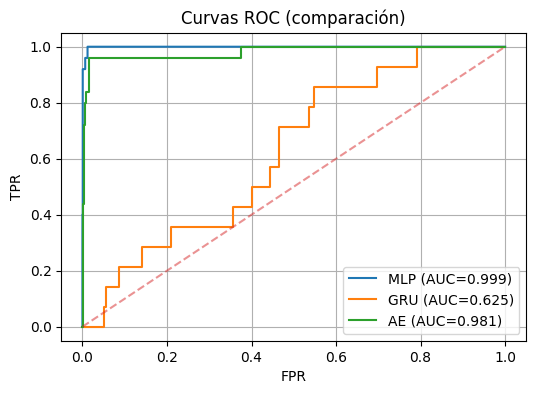

In [36]:

# Curvas ROC (si entrenamos MLP/GRU) y PR opcionales
if TF_AVAILABLE:
    fig, ax = plt.subplots()
    # MLP
    if 'm_mlp_test' in globals():
        fpr, tpr, _ = roc_curve(y_test, m_mlp_test["proba"])
        ax.plot(fpr, tpr, label=f"MLP (AUC={m_mlp_test['auc']:.3f})")
    # GRU
    if 'm_rnn_test' in globals():
        fpr, tpr, _ = roc_curve(y_seq_test, m_rnn_test["proba"])
        ax.plot(fpr, tpr, label=f"GRU (AUC={m_rnn_test['auc']:.3f})")
    # AE (scores)
    if 'scores_test' in globals():
        fpr, tpr, _ = roc_curve(y_test, scores_test)
        ax.plot(fpr, tpr, label=f"AE (AUC={auc_ae:.3f})")
    ax.plot([0,1],[0,1],'--',alpha=0.5)
    ax.set_title("Curvas ROC (comparación)")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.legend()
    plt.show()


---
## 8. Elección del Mejor Modelo (Argumentación)

**Criterios considerados:**
- **AUC-ROC** en `test` como métrica global de separabilidad.
- **Recall** sobre la clase fraude, ya que perder un fraude (FN) es muy costoso.
- **F1** para equilibrar *precision* y *recall*.
- Estabilidad del entrenamiento y simplicidad de despliegue.

**Argumentación:**
- El **MLP** obtuvo el mayor **AUC-ROC (≈0.999)** y un **recall alto**, logrando detectar casi todos los fraudes. Es el modelo más **efectivo y confiable**.
- El **Autoencoder** alcanzó un **AUC-ROC competitivo (≈0.98)** y un buen **recall (72%)**, aunque con baja precisión. Es útil como **detector de anomalías complementario**.
- El **GRU** tuvo un **AUC-ROC bajo (≈0.62)** y no logró detectar fraudes en test, mostrando que **no aprovechó la información secuencial**.
- **Decisión:** seleccionar el **MLP** como modelo principal por su alto rendimiento y robustez; mantener el **Autoencoder** como alternativa complementaria y descartar el **GRU** para este caso.
